# Week 3: representational similarity analysis (RSA)

This week's tutorial is about RSA! We'll be looking at how to transform patterns into RDMs using various distance measures, how to test the relation between feature-RDMs and brain-RDMs, and take a look at exploratory RDM visualization using multidimensional-scaling (MDS).

We will use data from the SharedStates dataset - a within-subject dataset used previously for a cross-decoding analysis (see [here](https://github.com/lukassnoek/SharedStates/blob/master/sharedstates_fullarticle_draft.pdf) for a draft of the corresponding article, which is currently in press). In the first couple of examples of this tutorial, we'll use the single-trial pattern estimates from the "self-task", in which subjects were shown short sentences about either emotional actions ("action" trials), emotional ("interoceptive") feelings ("interoception" trials), or emotional situations ("situation" trials). They were instructed to imagine as if they were experiencing/doing the actions/feelings/situations themselves (see figure below). <img src='self_task.png'>

The self-task was done twice (i.e. in two runs). Each run contained 20 trials of each condition (action, interoception, situation), so in total (across runs) we have 120 trials (20 trials \* 3 conditions \* 2 runs). While we applied a (cross-)decoding analysis on this dataset for the original study, we will apply some RSA techniques on this data for this week's tutorial. (The SharedStates dataset is, by the way, also one of the data-sets that you can use for your final project (more info on Blackboard/Week 4)).

In terms of skills, after this tutorial you are be able to:

* Create representational dissimilarity matrices (RDMs) from brain patterns using various metrics;
* Create custom "conceptual" feature-RDMs based on categorical conditions;
* Statistically test the similarity between feature- and brain-RDMS;
* Evaluate the explanatory power of your model relative to the data's noise using the *noise ceiling*;
* Create and test "computational" RDMs based on computationally-derived features;
* Exploratively visualize brain-RDMs with [MDS](http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html);

### Names
student 1: fill in your name ...

student 2: ... and the name of the person you're working with

In [1]:
# Some imports for the rest of the tutorial
import os.path as op
from glob import glob
import numpy as np
import nibabel as nib
from sklearn.metrics.pairwise import pairwise_distances
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading in and organizing data (yet again ...)
The SharedStates dataset is stored in the `/home/Public` folder again. Check out the folder (`/home/Public/SharedStates`) and its subfolders. You should see two directories - "SELF" and "OTHER" - which refer to the two tasks of the experiment. For the first part of the tutorial, you will work with data from the SELF task. Check out this directory: it should list several subdirectories referring to data from different subjects. Each subject contains two feat-directories referring to the two runs of the self-task. 

Let's check out the data from run 1 (`self1.feat`) for subject 3 (`sub003`). Look at the `design.png` file and make sure you understand the single-trial design. The `stats` directory contains the `tstat`-files corresponding to the single-trial-against-baseline contrasts. We want to load in these 60 files (\* 2, because there are two runs). 

<div class='alert alert-warning'>
**ToDo**: use `glob` to find *all* the tstat-paths belonging to *both* the runs from subject 3. So, you should find 120 paths. Hint: you need two wildcards.
</div>

In [2]:
base_dir = '/home/lukas/PatternAnalysis/week_4/SharedStatesData/SELF'
paths = glob('/home/lukas/PatternAnalysis/week_4/SharedStatesData/SELF/sub003/*.feat/stats/tstat*.nii.gz')

# We'll sort the paths for you so that it is ordered *tstat1.nii.gz (run1), *tstat1.nii.gz (run2), *tstat2.nii.gz (run1) etc
paths = sorted(paths, key=lambda x: int(op.basename(x).split('.')[0].split('tstat')[-1]))

Below, we copied the Mvp-class from last week (we took the one we put in the solutions from last week, but you may also copy your own if you want!). 

In [3]:
class Mvp():
    """ Custom class to load, organize, and process multivoxel MRI patterns. """
    
    def __init__(self, paths):
        
        self.paths = paths
        
    def load(self, voxel_dims=(91, 109, 91)):
        
        X = np.zeros((len(self.paths), np.prod(voxel_dims)))

        for i, path in enumerate(self.paths):
    
            X[i, :] = nib.load(path).get_data().ravel()
        
        self.X = X
    
    def standardize(self):
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)
        # Because the above line may divide by 0 for voxels outside the brain,
        # this leads to NaN (Not a Number) values. The line below sets all NaN values to 0.
        self.X[np.isnan(self.X)] = 0
        
    def apply_mask(self, path_to_mask, threshold):
        
        mask = nib.load(path_to_mask).get_data()
        mask_bool = mask > threshold
        self.X = self.X[:, mask_bool.ravel()]

<div class='alert alert-warning'>
**ToDo**: initialize an Mvp-object below with the paths you globbed in the previous ToDo. Name the object `sub003`. Then, load the paths (call the method load()). Note that the voxel-dimensions are 80\*80\*37 here (i.e. in native EPI space, not standard MNI space); we included the voxel-dimensions as an argument for the `load()` function, so use it accordingly. Do **not** standardize it (we'll explain why in a bit) and do not apply a mask.
</div>

In [4]:
# initialize the Mvp-object (and name it sub003)
sub003 = Mvp(paths=paths)
sub003.load(voxel_dims=(80, 80, 37))

### A note about standardization
Last week, you learned that you *need* to standardize your patterns (i.e. subtract the mean across samples and divide by the standard deviation across samples for all features (i.e. voxels) when we're working with ML algorithms. 

For RSA, however, you **shouldn't** standardize your patterns! It turns out that standardizing features leads to spurious (often negative) correlations between samples or conditions, which is of course detrimental for RSA. The reason for this is beyond the scope of this course (but see [this article](http://journal.frontiersin.org/article/10.3389/fnins.2013.00174/full) if you want to understand why this happens), but we thought you should know! 

## 2. Creating a 'conceptual model' RDM
In this section, we'll create a very simple 'conceptual model' RDM using the three conditions (action, interoception, situation) from the self-task. This conceptual model corresponds to the hypothesis that the distance between trials of the same condition are 0 and the distance between trials of different conditions is 1. If organized in a representational dissimilarity matrix (RDM), this would look like: <img src='conceptual_model.png'>

Importantly, we do not really use "world features" here, but we specify the RDM directly by *assuming* the dissimilarities between the samples (therefore, this type of model is often called a "conceptual" or "categorical" RDM). So, we're not "creating" a (feature-)RDM based on features, but based on an assumed (hypothesized) geometry. Later in the tutorial, we'll also test a computational model in which we *do* need to build a feature-RDM based on "world features" (instead of assuming a specific geometry).

But to create such a conceptual model RDM, we need to know to which condition (action, interoception, situation) each sample (trial) in our `Mvp` object belongs. One way is to manually write it down, given that you know which tstat-file belongs to which condition, like this:

`conditions = ['action', 'action', 'interoception', 'interoception', 'situation', 'situation', etc]`

If you have to do this for every subject, though, it becomes annoying and error-prone! Fortunately, there is also a "programmatic" way to do this. FSL in fact outputs a file called `design.con` when creating a `feat`-directory which lists the names you gave to the single-trial-against-baseline contrasts.

<div class='alert alert-warning'>
    **ToDo**: Check out the `design.con` file in the feat-directory of run1 (`self1.feat`) for subject 3 (just double-click the file, this will open the file in a text-editor). 
</div>

Although weirdly structured, you can see that the `design.con` file lists all the contrast-names, i.e. `actie_1`, `actie_2`, `interoception_1`, etc. (I accidentally used `actie`, the Dutch word for `action`). We have extracted the conditions for all the contrasts (single-trial estimates) for both runs for you already, which we stored in a text-file called `sample_labels.txt`. Below, we load in this file (and convert the list with strings to a numpy-array with strings):

In [8]:
labels = np.loadtxt('/home/lukas/PatternAnalysis/week_4/SharedStatesData/SELF/sub003/sample_labels.txt',
                    dtype=str)
labels = np.array(labels)
print(labels)

['Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Situation' 'Situation' '

<div class='alert alert-warning'>
**ToDo**: Programming challenge! Given the vector with labels of length *N* (N = number of samples), can you make a conceptual model RDM of shape *N*\**N*, in which cells corresponding to the same condition should be 0 and cells corresponding to different conditions should be 1 (basically, just like the image above)? Try to write it in a function - `make_conceptual_rdm(labels)` - that takes one argument (`labels`, a vector of length *N*) and returns an *N*\**N* RDM-matrix (a numpy array).<br><br>

**Note**: Do not assume that the labels are ordered (like it is now)! It should also work for vectors like `['A', 'A', 'B', 'C', 'B', 'A', 'B', etc]`<br>
**Hint**: it involves (at least) one for-loop.<br>
**Note**: This is meant as a programming exercise. Don't spend too much time on it! If you can't figure it out, you can use the function we have written, which is contained in `functions.py` (type `from functions import make_conceptual_rdm` to import the function).
</div>

In [9]:
def make_conceptual_rdm(y):
    rdm = np.vstack([y != y_tmp for y_tmp in y])
    return rdm.astype(int)

    # implement it here!    

If you want to test your function, run the cell below! It also visualizes your RDM and how the RDM should look like!

Your RDM is correct!


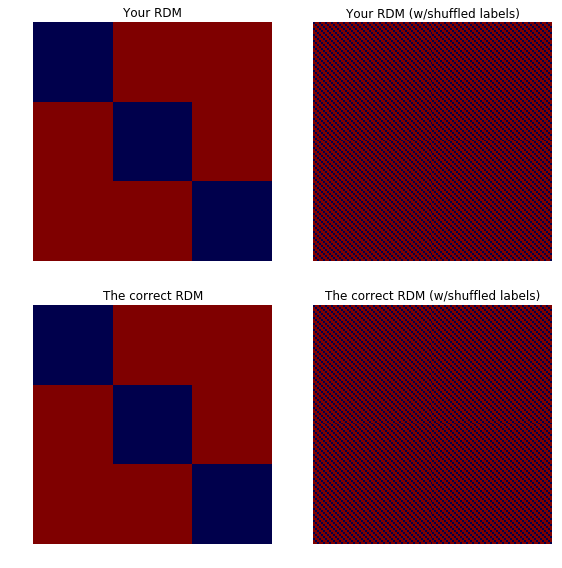

In [10]:
your_rdm = make_conceptual_rdm(labels)

# First check whether it really contains numbers (0 for same, 1 for different conditions)
assert(your_rdm.dtype != bool)

solution_rdm = np.load('solution_rdm.npy')

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.title('Your RDM')
plt.imshow(your_rdm, cmap='seismic')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title('The correct RDM')
plt.imshow(solution_rdm, cmap='seismic')
plt.axis('off')

# Check whether it is truly the same as the correct RDM
assert(np.sum(your_rdm == solution_rdm) == your_rdm.size)
print('Your RDM is correct!')

lab_shuf = [['actie', 'interoception', 'situation'] for i in range(40)]
lab_shuf = np.array([item for sublist in lab_shuf for item in sublist])

your_rdm_shuffled = make_conceptual_rdm(lab_shuf)
plt.subplot(2, 2, 2)
plt.title('Your RDM (w/shuffled labels)')
plt.imshow(your_rdm_shuffled, cmap='seismic')
plt.axis('off')

solution_shuffled_rdm = np.load('solution_shuffled_rdm.npy')

plt.subplot(2, 2, 4)
plt.title('The correct RDM (w/shuffled labels)')
plt.imshow(solution_shuffled_rdm, cmap='seismic')
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Creating your brain-RDM
While you specify your conceptual RDM directly, brain-RDMs have to be constructed by calculating distances between samples (in terms of their patterns in K-dimensional space). Therefore, when constructing brain-RDMs, you need to decide which distance metric you want to use. There are *very many* possible metrics (like correlation-distance, euclidean distance, mahalanobis distance, cityblock distance, etc. etc.), each with its own specific way of calculating distances, but fortunately they often yield very similar RDMs. 

Practically, calculating pairwise differences (i.e. sample 1 vs. sample 2, sample 1 vs. sample 3, etc. etc.) is quite tricky to implement (efficiently), as it involves N\*(N-1) pairwise distance calculations. Luckily, scikit-learn has a module that contains the function `pairwise_distances` ([link](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html#sklearn.metrics.pairwise.pairwise_distances)) that does exactly what we want: it takes a samples-by-feature matrix and transforms it into a samples-by-samples (i.e. N\*N) distance matrix, the *RDM*.

<div class='alert alert-warning'>
**ToDo**: Below, we import the pairwise_distances function. Check out the documentation (click the link in the above text-block). Now, in the code-block below, call the pairwise_distances function with `sub003.X` as input and metric set to 'euclidean'. Store the result in a variable named `brain_rdm`. Check the shape - it it indeed an $N\cdot N$ array?
</div>

In [11]:
from sklearn.metrics.pairwise import pairwise_distances
brain_rdm = pairwise_distances(sub003.X, metric='correlation')

Now, we can visualize RDMs using matplotlib's `imshow()` function:

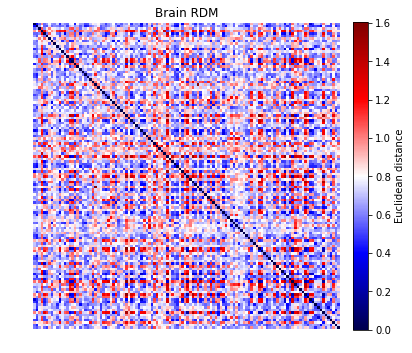

In [16]:
plt.figure(figsize=(6, 6))
plt.title('Brain RDM')
plt.imshow(brain_rdm, cmap='seismic')
plt.colorbar(label='Euclidean distance', fraction=0.046, pad=0.04)
plt.axis('off')
plt.show()

<div class='alert alert-info'>
**ToDo**: we just calculated and visualized an RDM based upon the Euclidean distance, but as discussed, there are many others. Below, we created a list with different metrics. Create a loop over these metrics, in which you create a new RDM using the corresponding metric and visualize it using `plt.imshow()` across 5 different subplots.  
</div>

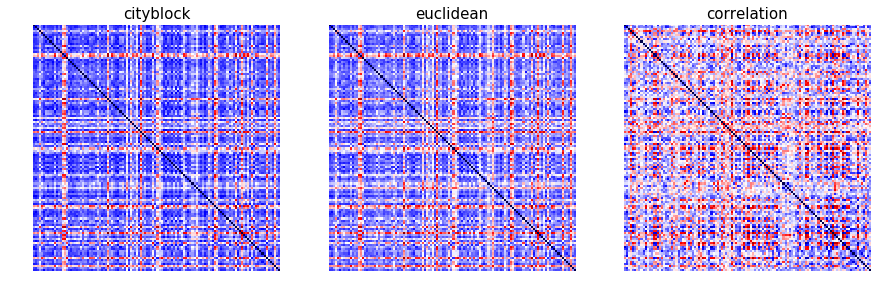

In [17]:
metrics = ['cityblock', 'euclidean', 'correlation']

plt.figure(figsize=(15, 15))

# Start your loop over metrics here (this may take a while!)
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    rdm = pairwise_distances(sub003.X, metric=metric)
    plt.title(metric, fontsize=15)
    plt.imshow(rdm, cmap='seismic')
    plt.axis('off')

plt.show()

<div class='alert alert-info'>
**(Advanced!) ToThink**: In the 3 subplots above, you clearly see that the `correlation` RDM is qualitatively different than the others (`cityblock` and `euclidean`). There is one factor that drives this difference. Can you figure out what this factor is? <br><br>

Hint 1: check out the formulas for the correlation distance and the euclidean distance between two vectors ("patterns") $p$ and $q$ which are of length $K$ (the amount of features/voxels), and have means $\bar{p}$ and $\bar{q}$:<br><br>

\begin{align}
\delta_{euclidean} = \sqrt{\sum_{i=1}^{K}{(p_{i} - q_{i})^{2}}}
\end{align}<br>


\begin{align}
\delta_{correlation} = 1-\frac{\sum_{i=1}^{K}((p_{i} - \bar{p})\cdot(q_{i} - \bar{q}))}{\sqrt{\sum_{i=1}^{K}{((p_{i} - \bar{p})^{2}\cdot(q_{i} - \bar{q})^{2})}}}
\end{align}

</div>

## 4. Testing RDMs
Alright, so now we got two RDMs: the conceptual model RDM (often called feature-RDM, or candidate-RDM) and the brain-RDM. To test whether our model (the conceptual model RDM) significantly explains our brain-RDM, we only have to correlate them, as depicted below:

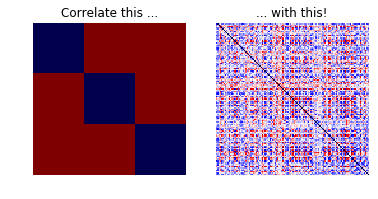

In [18]:
plt.subplot(1, 2, 1)
conc_rdm = np.load('solution_rdm.npy')
plt.title('Correlate this ...')
plt.imshow(conc_rdm, cmap='seismic')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('... with this!')
plt.imshow(rdm, cmap='seismic')
plt.axis('off')
plt.show()

Well, not yet. We first have to do one thing. You see, the RDMs are symmetric: the values above and below the diagonal are exactly the same. And this should indeed be the case, because the distance between A and B should be the same as the distance between B and A. Or, in pattern analysis terms: the correlation/euclidean/cosine distance between the pattern of sample 1 and pattern of sample 2 is the same as that distance between the pattern of sample 2 and the pattern of sample 1.

Anyway, if we'd use the entire (flattened!) RDMs, we'd "artifically" create twice as many datapoints (i.e. the pairwise dissimilarities) than there really are, which will inflate the (significance of the) correlation between the RDMs (because of increased degrees of freedom). So, instead of using all $N\cdot N$ pairwise differences from the RDM, we need to extract only the $N\cdot(N-1)/2$ pairwise dissimilarity values (thus excluding the diagonal!).

Fortunately, numpy has a function to extract the upper (or, equivalently, lower) "triangle" of a square matrix (like our RDM) called `np.triu_indices` (triu = triangle upper; equivalent to `np.tril_indices` = triangle lower). This function gives the indices for the lower traingle of any $N\cdot N$ square matrix. Additionally, by using these indices to index the RDM, we ravel (flatten) the lower-triangle-extracted matrix into a vector, which is obviously necessary when we want to compute the correlation between them (because we cannot correlate matrices!). 

<div class='alert alert-warning'>
**ToDo**: Use the function `np.triu_indices` to extract the upper triangle of both the conceptual model RDM and the brain-RDM (store them in the variables `conc_rdm_triu` and `brain_rdm_triu` respectively). Check the [documentation](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.triu.html) on how the `np.triu_indices` works (note: the function refers to $N$ as $m$). Also, by default the function includes the diagonal (which we don't want to include!), so you might have to fiddle with the `k` parameter in the function ... Make sure that your newly created variables are of size $N\cdot (N-1)/2$.
</div>

In [12]:
# use np.triu_indices to index both conc_rdm and brain_rdm
conc_rdm_triu = conc_rdm[np.triu_indices(conc_rdm.shape[0], k=1)]
brain_rdm_triu = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]

In [13]:
# also, check if your new variables are indeed of size N*(N-1)/2


Alright, finally we can test the correlation between the two (flattened) RDMs! Given that we're using a conceptual model (distance same condition = 0, distance different condition = 1), this tests whether, on average, brain patterns corresponding to samples from the same condition are more similar than brain patterns corresponding to samples from different conditions. 

Anyway, there is still one decision we need to make: what type of correlation should we choose? We could straightforwardly pick the convential Pearson correlation, but then we'd have to assume that the relationship between the feature-RDM and the brain-RDM is linear. For this and other reasons (see the appendix in [this article](http://journal.frontiersin.org/article/10.3389/neuro.06.004.2008/full) for more info), usually non-parametric correlations like the Spearman rank correlation or Kendall's Tau ($a$ version) are preferred. Here, we'll use the Spearman correlation.

<div class='alert alert-warning'>
**ToDo**: below, we import the `spearmanr` function (see [doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)). Calculate the spearman correlation between the feature-RDM (conceptual model RDM) and the brain-RDM.
</div>

In [14]:
from scipy.stats import spearmanr
spearmanr(conc_rdm_triu, brain_rdm_triu)

SpearmanrResult(correlation=0.03044714013701591, pvalue=0.010085491490284594)

<div class='alert alert-info'>
**ToThink**: In the previous ToDo, you should have found that the correlation between the conceptual RDM and the brain-RDM was about .03, which was significant ($p$ = 0.01). This p-value is, however, not valid, because the data (i.e. the RDMs) violate an assumption of the (Spearman) correlation. Can you think of which assumption this could be? (Hint: it's a similar assumption our data violates that we encountered in statistical tests of between-subject accuracy estimates.). Do you also know a solution? That is, do you know an alternative way to assess significance of this correlation?
</div>

Alright, that were basically all the steps necessary for a (subject-wise) RSA pipline. In summary, we did the following:

- Defined a candidate (feature-) RDM based on categorical distinctions;
- Loaded the brain-data in a samples-by-features format;
- Calculated the brain-RDM based on pairwise correlation distances;
- Computed the correlation between the feature-RDM and the brain-RDM

Now, usually we do not have a single subject (here: sub003) in our dataset, but multiple subjects. In that case, we'd perform the RSA pipeline on each subject, yielding a vector of subject-wise correlations of feature/brain RDMs, which can then subsequently be tested against zero using a (non-parametric) one-sample t-test. And this is exactly what you'll do in the next assignment!

<div class='alert alert-danger'>
**Assignment 1** (4 points): For this assignment, you should perform the analysis in which we correlated the conceptual model RDM with the brain-RDM *for each subject*. So, *glob* all subjects paths (i.e. `/home/Public/SharedStates/SELF/sub002`, `/home/Public/SharedStates/SELF/sub003`, etc.) and loop over it. Within the loop, do the following:<br><br>

- glob the tstat-paths from *both* feat-directories, and sort them like we did previously (with the key=lambda x ...);<br>
- initialize an Mvp-object, and load the paths;<br>
- load the `sample_labels.txt` file and create the conceptual model RDM based on the condition-labels;<br>
- create a brain-RDM using the `pairwise_distances` function (use `metric=correlation`);<br>
- extract the lower (or upper) triangle of each RDM;<br>
- store the computed (lower-triangle-extract) brain-RDM vector in the pre-allocated variable `brain_rdms` (which we initialized already for you in the code block below), because we need this data in the next part of the tutorial;<br>
- calculate the spearman correlation between the two resulting vectors and store the correlation-value (not the p-value);<br>
- then, when you have 19 correlation values (there are 19 subjects), use a one-sample non-parametric t-test - called the [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) - to test whether the average correlation value is significantly above chance. You can use the `wilcoxon` function from the `scipy.stats` package (you have to import it first, of course).<br><br>

**Hint**: you should find that the mean spearman correlation is x.

</div>

In [21]:
brain_rdms = np.zeros((120*(120-1)/2, 19))
subs = sorted(glob(base_dir + '/sub*'))
sub_rs = np.zeros(len(subs))
for i, sub in enumerate(subs):
    print(op.basename(sub))
    paths = glob(sub + '/*.feat/stats/tstat*.nii.gz')
    paths = sorted(paths, key=lambda x: int(op.basename(x).split('.')[0].split('tstat')[-1]))
    mvp = Mvp(paths=paths)
    mvp.load(voxel_dims=(80, 80, 37))
    #mvp.apply_mask(glob(sub + '/*.feat/reg/GrayMatter_epi.nii.gz')[0], 30)
    brdm = pairwise_distances(mvp.X, metric='correlation')
    brain_rdms[:, i] = extract_lower(brdm)
    sub_rs[i] = stats.spearmanr(conc_rdm_triu, extract_lower(brdm))[0]

sub002


NameError: name 'extract_lower' is not defined

In [76]:
print(np.mean(sub_rs))
from scipy.stats import wilcoxon
wilcoxon(sub_rs)

0.0515284995999


WilcoxonResult(statistic=4.0, pvalue=0.00016285576606790404)

## 5. The noise ceiling
Sweet! In the previous assignment we found out that our conceptual model explains a significant amount of variance of our brain RDM. But, significance aside, we should ask ourselves: is this a (reasonably) *good* model? Surely, a 0.05 average correlation ($\rho$) is not quite high, given that correlations are expressed in a range from -1 (which would indicate a *horrible* model) to 1 (which would indicate a *perfect* model). On the other hand, we can ask ourselves what range of correlations we can reasonably expect *given the noise in our data*. We know that fMRI data (and thus pattern estimates/correlations) are extremely noisy, so maybe we should adjust our expectations about what a reasonable average correlation of our model with the brain-RDM would be.

Turns out that there is indeed a way to estimate an "upper bound" of model performance given the noise in your data: the **noise ceiling**. The noise ceiling represents the highest correlation ($\rho$) of any model to the brain-RDM that we can expect given the noise in the data. Usually (but depending on what type of correlation you use), it is calculated as the average (spearman) correlation of each subject's brain-RDM with the average brain-RDM across subjects (see the image below). <img src='noise_ceiling.png'>

<div class='alert alert-warning'>
**ToDo** (maybe assignment?): Remember that we saved the subject-specific RDMs in the `brain_rdms` variable? With this data, you can now calculate the noise ceiling for this analysis. So, do the following:<br><br>

- calculate the average RDM (average across subjects);<br>
- loop over subjects and correlate the subject-specific RDM to the average RDM;<br>
- finally, average across the subject-specific correlations to the average RDM to find the noise ceiling!
</div>

In [70]:
# Find the noise ceiling!


In [81]:
mean_rdm = brain_rdms.mean(axis=-1)
subj_corrs = np.array([spearmanr(mean_rdm, brain_rdms[:, i])[0]
                       for i in range(brain_rdms.shape[-1])])
print(subj_corrs.mean())

0.291068262604


## 6. Testing computational models with RSA

In [23]:
from skbold.core import convert2epi
feat_rdms = np.zeros((90*(90-1)/2, 19))
brain_rdms = np.zeros_like(feat_rdms)
subs = sorted(glob(op.dirname(base_dir) + '/OTHER/sub*'))
sub_rs = np.zeros(len(subs))
brain_patterns = np.zeros((90, 90, len(subs)))

for i, sub in enumerate(subs):
    print(op.basename(sub))
    paths = glob(sub + '/*.feat/stats/tstat*.nii.gz')
    paths = sorted(paths, key=lambda x: int(op.basename(x).split('.')[0].split('tstat')[-1]))
    mvp = Mvp(paths=paths)
    mvp.load(voxel_dims=(80, 80, 37))
    mask = convert2epi('occipitalpole.nii.gz', reg_dir=glob(sub + '/*.feat/reg')[0],
                       out_dir=glob(sub + '/*.feat/reg')[0])
    mvp.apply_mask(mask, 0)
    brdm = pairwise_distances(mvp.X, metric='correlation')
    brain_patterns[:,:, i] = brdm
    brain_rdms[:, i] = extract_lower(brdm)
    
    feats = np.load(glob(op.join(sub, '*.feat', 'grayscale_complexity_params.npy'))[0])
    frdm = pairwise_distances(feats, metric='correlation')
    feat_rdms[:, i] = extract_lower(frdm)
    sub_rs[i] = stats.pearsonr(feat_rdms[:, i], brain_rdms[:, i])[0]
print(sub_rs.mean())

sub002
sub003
sub004
sub005
sub006
sub007
sub009
sub010
sub011
sub012
sub013
sub018
sub020
sub021
sub022
sub023
sub024
sub025
sub027
0.0199659689133


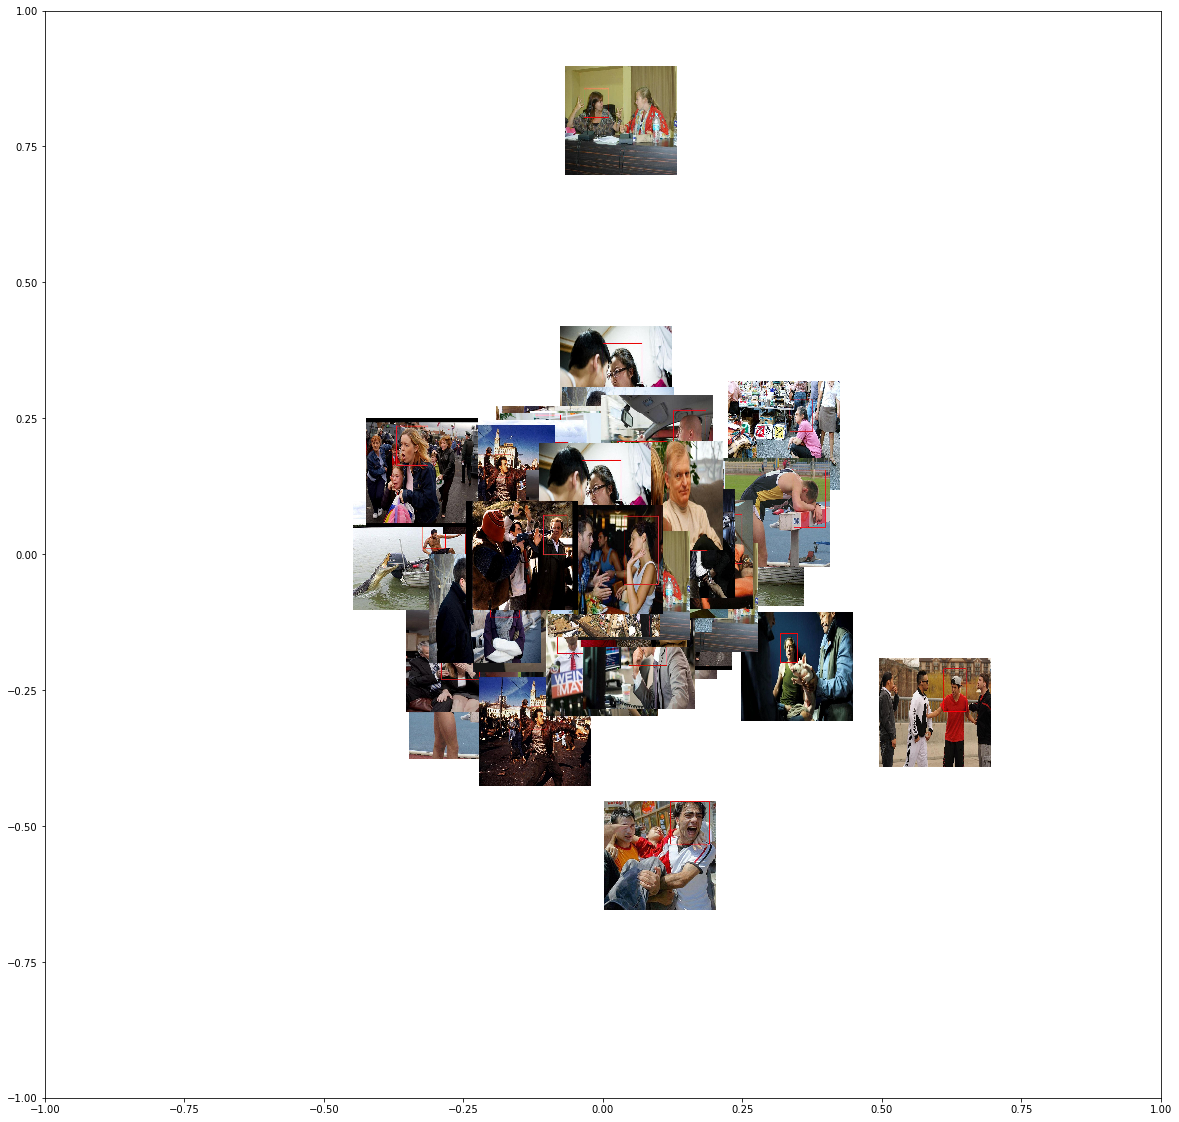

In [26]:
from sklearn.manifold import MDS
mds = MDS(dissimilarity='precomputed')
mdscoor = mds.fit_transform(brdm)

stimseq = np.loadtxt(sub + '/sub027-other.feat/stim_sequence.txt', dtype=str)
stims = [s.split('-')[-1] for s in stimseq]
plt.figure(figsize=(20, 20))
for i, stim in enumerate(stims):
    stim = '0' + stim[1:] if int(stim[1]) != 0 else '00' + stim[2:]
    im = plt.imread('/home/lukas/PatternAnalysis/week_4/SharedStatesData/images/%s' % stim)
    coords = (mdscoor[i, 0] - .1, mdscoor[i, 0] + .1,
                                          mdscoor[i, 1] - .1, mdscoor[i, 1] + .1)
    plt.imshow(im, aspect='auto', extent=coords)
#ax.scatter(mdscoor[:, 0], mdscoor[:, 1])
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.show()

In [22]:
def extract_lower(rdm):
    return rdm[np.triu_indices(rdm.shape[0], k=1)]
    

    
def test_rdm(X, candidate_rdm, dist_func, corr_func, average=False, mask=None):
    
    if average:
        X = (X[::2, :] + X[1::2, :]) / 2.0
        candidate_rdm = candidate_rdm[::2, ::2]
    
    if mask is not None:
        X = X[:, mask]
    
    brain_rdm = pairwise_distances(mvp.X, metric=dist_func)
    brain_rdm = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
    candidate_rdm = candidate_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
    score = corr_func(brain_rdm, candidate_rdm) 
    
    if isinstance(score, (list, tuple)):
        score = score[0]
    return score

In [2]:
# TEST OTHER MODEL

mask_names = sorted(parse_roi_labels(atlas_type='HarvardOxford-Cortical', lateralized=True).keys())
subs = sorted(glob('/media/lukas/data/PatternAnalysis/week_4/SharedStatesData/OTHER/sub*'))

scores = np.zeros((len(subs), len(mask_names)))

for i, sub_path in enumerate(subs):
    sub = op.basename(sub_path)
    print(sub)
    reg_dir = sub_path + '/%s-self1.feat/reg' % sub
    path = sub_path + '/*.feat/stats/tstat*.nii.gz'
    paths = sorted(glob(path), key=lambda x: int(op.basename(x).split('.')[0].split('tstat')[-1]))
    masks = load_roi_mask('all', atlas_name='HarvardOxford-Cortical',
                          lateralized=True, threshold=0, reg_dir=reg_dir, which_hemifield='left')

    for ii, mask in enumerate(masks):
        mvp = Mvp(paths)
        mvp.load(voxel_dims=(80, 80, 37))
        mvp.X = mvp.X[:,mask.ravel()]
        mvp.X = (mvp.X[0::2, :] + mvp.X[1::2, :]) / 2.0
        mvp.X = mvp.X[:, mask]
        brdm = pairwise_distances(mvp.X, metric='correlation')
        brain_patterns[:,:, i] = brdm
        brain_rdms[:, i] = extract_lower(brdm)
    
        feats = np.load(glob(op.join(sub, '*.feat', 'grayscale_complexity_params.npy'))[0])
        frdm = pairwise_distances(feats, metric='correlation')
        feat_rdms[:, i] = extract_lower(frdm)
        sub_rs[i, ii] = stats.spearmanr(feat_rdms[:, i], brain_rdms[:, i])[0]
print(scores)

In [ ]:
# OLD CODE TO EXTRACT STIMULI SEQUENCE
lud = {'Actie': 0,
       'Interoception': 1,
       'Situation': 2}

mask_names = sorted(parse_roi_labels(atlas_type='HarvardOxford-Cortical', lateralized=True).keys())
subs = sorted(glob('/media/lukas/data/PatternAnalysis/week_4/SharedStatesData/SELF/sub*'))

scores = np.zeros((len(subs), len(mask_names)))

for i, sub_path in enumerate(subs):
    sub = op.basename(sub_path)
    print(sub)
    reg_dir = sub_path + '/%s-self1.feat/reg' % sub
    path = sub_path + '/*.feat/stats/tstat*.nii.gz'
    paths = sorted(glob(path), key=lambda x: int(op.basename(x).split('.')[0].split('tstat')[-1]))
    labels = extract_condition_names(sub_path + '/%s-self1.feat/design.con' % sub)
    labels.extend(labels)
    labels = sorted(labels)
    labels = np.array([lud[tmp] for tmp in labels])
    cat_rdm = generate_categorical_rdm(labels)

    masks = load_roi_mask('all', atlas_name='HarvardOxford-Cortical',
                          lateralized=True, threshold=0, reg_dir=reg_dir, which_hemifield='left')

    for ii, mask in enumerate(masks):
        mvp = Mvp(paths)
        mvp.load(voxel_dims=(80, 80, 37))
        mvp.X = mvp.X[:,mask.ravel()]
        mvp.X = (mvp.X[0::2, :] + mvp.X[1::2, :]) / 2.0
        brain_rdm = pairwise_distances(mvp.X, metric='correlation')
        brain_rdm_triu = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
        cat_rdm_tmp = cat_rdm[::2]
        cat_rdm_triu = cat_rdm_tmp[np.triu_indices(brain_rdm.shape[0], k=1)]
        scores[i, ii] = stats.spearmanr(brain_rdm_triu, cat_rdm_triu)[0]
print(scores)

In [ ]:
# OLD CODE TO FIND STIM SEQ
features = np.load('scene_statistics.npz')
simple, rgb = features['simple'], features['rgb']
logs = glob(op.join('/home/lukas/PatternAnalysis/week_4/SharedStatesData/OTHER', 'sub*', '*.feat', '*.log'))
lud = {'What': 'Interoception',
       'How': 'Action',
       'Why': 'Situation'}


for log in logs:
    df = pd.read_csv(log, sep='\t', skiprows=3)['Code']
    df = df.iloc[2:].tolist()
    stims = []
    counters = {'Action': 1,
            'Interoception': 1,
            'Situation': 1}
    
    for code in df:
        
        if str(code)[:3] == 'Cue':
            current_cond = lud[code.split(' ')[-1]] 
        
        if str(code).isdigit():
            
            if int(code) > 100:
                stims.append(current_cond + '_%i-%s.jpg' % (counters[current_cond],
                                                            str(code)))
                counters[current_cond] += 1
    
    np.savetxt(op.join(op.dirname(log), 'stim_sequence.txt'), sorted(stims), fmt='%s')
    simple_stats = simple[[int(s.split('-')[-1].split('.')[0][1:]) -1 for s in stims], :]
    np.save(op.join(op.dirname(log), 'grayscale_complexity_params.npy'), simple_stats)
    rgb_stats = rgb[[int(s.split('-')[-1].split('.')[0][1:]) -1 for s in stims], :]
    np.save(op.join(op.dirname(log), 'rgb_complexity_params.npy'), rgb_stats)